In [1]:
import pandas as pd
# numpy 2.0 for bitwise count operations
import numpy as np
import json
import operator
import itertools 
import matplotlib.pyplot as plt
import re
import subprocess
import seaborn as sns
from scipy.stats import beta,binom,betabinom
#manual install from: https://github.com/allefeld/pytikz.git uncomment to install:
#!pip install git+https://github.com/allefeld/pytikz.git
import tikz
import pickle


## Parameters

Datasets, algorithms and approximation factors used in the experiments.

In [2]:
#Datasets
dataDir="./datasets/"
datasetNames=[
    "airport",
    "flights",
    "food",
    "Hospital",
    "ncvoter",
    "tax500k",
]
rowCount=2**14

In [3]:
#Algorithms
JARDir="./algorithmJARs/"
algorithms=[
    "FastDC",
    "Hydra",
    "DCFinder",
    "ADCMiner",
    "FastADC",
]

In [4]:
#Approximation factors to be used by algorithms
aproximations=["0.00","0.00000001","0.000001","0.0001","0.01"]
aproxexp=["0","10^{-8}","10^{-6}","10^{-4}","10^{-2}"]


# Code

Classes used to represent datasets and Denial Constraints.

In [5]:
class Operator:
    def __init__(self,func,expFunc) -> None:
        self.func=func
        self.expFunc=expFunc
        self.neg=None
        self.imp=None
    def __call__(self,a,b):
        return self.func(a,b)
    def negate(self):
        return Operator(operator.invert(self.func))
    def expected(self,c1,c2):
        return self.expFunc(c1,c2)
    def __repr__(self) -> str:
        return revopmap[self]
    def __eq__(self, other: object) -> bool:
        if isinstance(other, Operator):
            return self.func==other.func
        return False
    def __hash__(self):
        fields=(self.func)
        hash_value = hash(fields)
        return hash_value

def eqExp(l,r):
    n=sum(l)**2
    return np.sum(l**2)/n
       

eq=Operator(operator.eq,eqExp)

def neExp(l,r):
    n=sum(l)
    return 1-np.sum(l**2)/n**2
ne=Operator(operator.ne,neExp)

def geExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq))/n**2
ge=Operator(operator.ge,geExp)

def leExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq+l))/n**2
le=Operator(operator.le,leExp)

def gtExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(cumFreq-l))/n**2
gt=Operator(operator.gt,gtExp)

def ltExp(l,r):
    n=sum(l)
    cumFreq=np.cumsum(l)
    return np.sum(l*(n-cumFreq))/n**2
lt=Operator(operator.lt,ltExp)
operatorMap={
    "EQUAL":eq,
    "UNEQUAL":ne,
    "LESS_EQUAL":le,
    "GREATER_EQUAL":ge,
    "LESS":lt,
    "GREATER":gt
}

opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
revopmap={y:x for x,y in opmap.items()}

eq.neg=ne
ne.neg=eq
gt.neg=le
le.neg=gt
lt.neg=ge
ge.neg=lt

eq.imp=[ge,le,eq]
ne.imp=[ne]
gt.imp=[gt,ge,ne]
lt.imp=[lt,le,ne]
ge.imp=[ge]
le.imp=[le]


#wrong implications to avoid DCs of the sort > -> !=
eq.imp=[ge,le,eq]
ne.imp=[ne,lt,gt]
gt.imp=[gt,ge]
lt.imp=[lt,le]
ge.imp=[ge]
le.imp=[le]


class Predicate:
    def __init__(self,l:str,op:Operator,r:str) -> None:
        self.l=l
        self.r=r
        self.op=op
        self.exp=None
         

            
    
    def __repr__(self) -> str:
        return 't0.'+self.l +' '+self.op.__repr__()+' t1.'+self.r+''
    def __hash__(self):
        fields=(self.l,self.r)
        hash_value = hash(fields)
        return hash_value

    def __eq__(self, other):
        if isinstance(other, Predicate):
            sFields=(self.l,self.op,self.r)
            oFields=(other.l,other.op,other.r)
            return sFields==oFields
        return False
    def impliesPred(self,other):
        #True if predicate being false implies other being false
        return self.l==other.l and self.r==other.r and other.op.neg in self.op.neg.imp




class Dataset:
    def __init__(self,file,**args):
        self.columns=pd.read_csv(file,nrows=0).columns
        self.header=[re.match(r'([^\(\)]*)(?:\(| )([^\(\)]*)\)?',col) for col in self.columns]
        self.names=[match[1] for match in self.header]
        typeMap={'String':str,'Integer':float,'Int':float,'Double':float,'int':float,'str':str,'float':float}
        self.types={col:typeMap[match[2]] for col,match in zip(self.columns,self.header)}
        
        self.df=pd.read_csv(file,**args,dtype=self.types)
        for i,col in enumerate(self.columns):
            self.df[col]=self.df[col].astype(self.types[col])
        
    def randRows(self,n):
        ids=np.random.randint(0,len(self.df),n)
        return self.df.iloc[ids]
    def randFields(self,n):
        return pd.DataFrame({col:dfs[col].iloc[list(np.random.randint(0,len(dfs),n))].values for dfs in [self.df] for col in dfs.columns})

    def buildPLIs(self):
        self.PLI= {col:self.df.groupby(by=col).groups for col in self.df}
        self.PLILen={col:np.array([len(self.PLI[col][v])for v in self.PLI[col]]) for col in self.df}
        self.vals={col:np.array([v for v in self.PLI[col]]) for col in self.df}
    def shuffle(self):
        self.df=self.randFields(len(self.df))

    def buildPreds(self):
        self.preds=[]
        self.predMap={}
        self.colPreds=[]
        self.predCols=[]
        
        for col in self.columns:
            ops=[eq,ne] if self.types[col] ==str else [eq,ne,gt,ge,lt,le]
            self.colPreds.append([]) 
            for op in ops:
                pred=Predicate(col,op,col)
                self.predMap[(col,op,col)]=len(self.preds)
                self.predCols.append(len(self.colPreds))
                self.colPreds[-1].append(len(self.preds))
                self.preds.append(pred)
                
                
                
                
    
    def buildEvi(self):
        n=len(self.df)
        m=len(self.preds)
        self.eviSize=n*(n-1)

        self.evi=[None]*m
        self.predProbs=[None]*m
        
       
        for p in range(m):
            pred=self.preds[p]
            col=self.df[pred.l]
            evis=[]
            for i in range(n):
                c1=col.iloc[i]
                c2=col.iloc[i+1:n]
                evis.append(pred.op(c1,c2))
                c2=col.iloc[:i]
                evis.append(pred.op(c1,c2))

            allTPs=np.concatenate(evis)
            self.evi[p]=np.packbits(allTPs,axis=0,bitorder='little')
            self.predProbs[p]=allTPs.sum()/(n*(n-1))*2
        self.sortedPreds=sorted(range(len(self.predProbs)),key=lambda i:self.predProbs[i])
                


class DenialConstraint:
    def __init__(self,preds) -> None:
        self.preds=preds
        
    def __sub__(self,other):
        return DenialConstraint(self.preds-other.preds)
    def __le__(self,other):
        other:DenialConstraint=other
        return all([ any([p==pp for pp in other.preds]) for p in self.preds])

    def __eq__(self, value: object) -> bool:
        return self<=value and value<=self
    def __repr__(self) -> str:
        return "¬("+" ^ ".join([pred.__repr__() for pred in self.preds])+")"
    
    
    


class DenialConstraintSet:
    def __init__(self,path,dataset,dss,algorithm) -> None:        
        self.predMap={}
        self.preds=[]
        self.dss=dss
        opmap={"==":eq,"<>":ne,">=":ge,"<=":le,">":gt,"<":lt}
        def getPred(c1,op,c2):
            op=opmap[op]
            return dss.predMap[(c1,op,c2)]
        
        self.DCs=[]
        
        with open(path) as f:
            for line in f:
                line=line.strip()[2:-1] #strip !(...)
                preds=line.split('^')
                regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
                if algorithm in ['ADCMiner','FastADC','ours']:
                    regex=r't0\.([^=><]*) (==|<>|>=|<=|>|<) t1\.([^=><]*)'
                preds = [getPred(*re.match(regex,pred.strip()).groups()) for pred in preds]
                self.DCs.append(preds)

    def buildGraph(self):
        self.root=[{},None]
        for dc in self.DCs:
            node=self.root
            for pred in sorted(dc):
                if pred not in node[0]:
                    node[0][pred]=[{},None]
                node=node[0][pred]
            node[1]=dc

    def getReduced(self):
       
        notImplied=[True]*len(self.DCs)

        def impliesDC(dc1,dc2):
            return all([any([self.dss.preds[pred].impliesPred(self.dss.preds[otherpred]) for otherpred in dc2]) for pred in dc1])

        for i,dc1 in enumerate(self.DCs):
            for j,dc2 in enumerate(self.DCs):
                if impliesDC(dc1,dc2):
                    if impliesDC(dc2,dc1):
                        notImplied[j]=notImplied[j] and j<=i
                    else:
                        notImplied[j]=False
        return [dc for i,dc in enumerate(self.DCs) if notImplied[i]]
        

<>:232: SyntaxWarning: invalid escape sequence '\.'
<>:232: SyntaxWarning: invalid escape sequence '\.'
<>:232: SyntaxWarning: invalid escape sequence '\.'
<>:232: SyntaxWarning: invalid escape sequence '\.'
/tmp/ipykernel_4550/669333522.py:232: SyntaxWarning: invalid escape sequence '\.'
  regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'
/tmp/ipykernel_4550/669333522.py:232: SyntaxWarning: invalid escape sequence '\.'
  regex=r't0\.'+dataset+'\.csv\.([^=><]*)(==|<>|>=|<=|>|<)t1\.'+dataset+'\.csv\.([^=><]*)'


# Results

Code to obtain the results

In [6]:
#load datasets
datasets={}
for name in datasetNames:
    print(name)
    datasets[name]=Dataset(dataDir+name+".csv",nrows=rowCount//8,encoding='unicode_escape')
    datasets[name].buildPLIs()
    datasets[name].buildPreds()
    #datasets[name].buildEvi()


airport
flights
food
Hospital
ncvoter
tax500k


## Discover DCs

Runs every combination algorithm/dataset/approximation and stores the results. Long execution time, compressed results stored from previous executions can be loaded with the last cell.

In [ ]:
i=0
start=0
for dataset in datasetNames:
    for algorithm in algorithms:
        for aprox in ["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]:
            i+=1
            if i<start:
                continue
            print(f"---------------ITERATION: {i}")
            print("RUN: {}_{}_{}".format(algorithm,dataset,aprox))
            #Use -Xmx12g if needed
            command='java -jar {} {} {} {}'.format(JARDir+algorithm+'.jar',dataDir+dataset+".csv",aprox,rowCount)
            result = subprocess.run(command, shell=True)
            print("MOVE: {}_{}_{}".format(algorithm,dataset,aprox))
            command='mv output.txt results/{}_{}_{}'.format(algorithm,dataset,aprox)
            result = subprocess.run(command, shell=True)



In [ ]:
# Save results 
%cd ./results/
!zip  ./DiscoveredDCs.zip ./*_*_*
%cd -

In [ ]:
# Load results 
%cd ./results/
!unzip  -n ./DiscoveredDCs.zip
%cd -

## Compute DC satisfactions


In [7]:
#Load DC discovery algorithm results
discoveredDCs={}
for dataset in datasetNames:
    ds=datasets[dataset]
    for algorithm in algorithms[:]:
        aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
        for aprox in aproxs:
            print("{}_{}_{}".format(algorithm,dataset,aprox))
            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,ds,algorithm)
            discoveredDCs[(algorithm,dataset,aprox)]={frozenset(preds) for preds in dcs.DCs}

FastDC_airport_0.00
Hydra_airport_0.00
DCFinder_airport_0.00
DCFinder_airport_0.00000001
DCFinder_airport_0.000001
DCFinder_airport_0.0001
DCFinder_airport_0.01
ADCMiner_airport_0.00
ADCMiner_airport_0.00000001
ADCMiner_airport_0.000001
ADCMiner_airport_0.0001
ADCMiner_airport_0.01
FastADC_airport_0.00
FastADC_airport_0.00000001
FastADC_airport_0.000001
FastADC_airport_0.0001
FastADC_airport_0.01
FastDC_flights_0.00
Hydra_flights_0.00
DCFinder_flights_0.00
DCFinder_flights_0.00000001
DCFinder_flights_0.000001
DCFinder_flights_0.0001
DCFinder_flights_0.01
ADCMiner_flights_0.00
ADCMiner_flights_0.00000001
ADCMiner_flights_0.000001
ADCMiner_flights_0.0001
ADCMiner_flights_0.01
FastADC_flights_0.00
FastADC_flights_0.00000001
FastADC_flights_0.000001
FastADC_flights_0.0001
FastADC_flights_0.01
FastDC_food_0.00
Hydra_food_0.00
DCFinder_food_0.00
DCFinder_food_0.00000001
DCFinder_food_0.000001
DCFinder_food_0.0001
DCFinder_food_0.01
ADCMiner_food_0.00
ADCMiner_food_0.00000001
ADCMiner_food_0.

For every discovered DC (and some subsets) compute statistics like satisfaction and expected satisfaction under independence. Long execution time, cell before last allows to load previously saved results.

In [ ]:
#Compute satisfaction of accepted DCs on data
results={}
for dataset in datasetNames:
    print("Load dataset"+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=2**12,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    ds.buildEvi()
    print("Loaded dataset "+str(dataset))
    for algorithm in algorithms[:]:
        aproxs=["0.00","0.00000001","0.000001","0.0001","0.01"] if algorithm not in ['Hydra','FastDC'] else ["0.00"]
        for aprox in aproxs:
            print("{}_{}_{}".format(algorithm,dataset,aprox))

            dcs=DenialConstraintSet("results/{}_{}_{}".format(algorithm,dataset,aprox),dataset,ds,algorithm)
            dcs.buildGraph()
            res={}
            def search(b,s,x,node,prob=1):
                res[s]=(np.sum(np.bitwise_count(x))/ds.eviSize,prob,node[1] is not None)

                for i in range(b,len(ds.preds)):
                    if i in node[0]:
                        search(i+1,s|{i},np.bitwise_and(x,ds.evi[i]),node[0][i],prob*ds.predProbs[i])

            search(0,frozenset(),np.full((ds.eviSize//8,),255,dtype=np.uint8),dcs.root)

            results[(algorithm,dataset,aprox)]=res

In [19]:
# Save results
with open("results/DCSatisfactions", 'wb') as file:
        pickle.dump(results,file)

%cd ./results/
!zip  ./DCSatisfactions.zip ./DCSatisfactions
%cd -

In [7]:
# Load results 
%cd ./results/
!unzip  -n ./DCSatisfactions.zip
%cd -

with open("results/DCSatisfactions", 'rb') as file:
        results=pickle.load(file)

/mnt/c/Users/Albert/Desktop/uni/master/tfm/repo/new/4/DCValidity/results


/root/.local/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


Archive:  ./DCSatisfactions.zip
/mnt/c/Users/Albert/Desktop/uni/master/tfm/repo/new/4/DCValidity


In [8]:
#DC Satisfactions are computed for every DC in the set, along with the necessary subsets to reach them from the empty set. See buildGraph() function.
#For experimenting, we need all the information
#For plotting, only information about discovered DCs is needed
#Run if using the notebook as is to reproduce the plots
results={x: {dc:results[x][dc] for dc in results[x] if results[x][dc][2]}  for x in results}

## Compute number of tuple pairs satisfying each node

Enumerates sets of predicates up to a certain size and computes its satisfaction. Long execution time, last cell allows loading precomputed results from previous executions.

In [8]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)))

In [ ]:
#Our results
depth=4
DCCounts={}
for dataset in datasetNames:

    
    print("Load dataset "+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=rowCount//2,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    ds.buildEvi()
    print("Loaded dataset "+str(dataset))
    counts={}
    
    def search(preds,cols,x):

        
        counts[preds]=np.bitwise_count(x).sum()
        if len(preds)>=depth:
             return
            
        for pred in ds.sortedPreds:
                ncol=ds.predCols[pred]
                if ncol in cols:
                    continue
                npreds=preds|{pred}
                ncols=cols|{ncol}
                if npreds in counts:
                    continue

                newx=np.bitwise_and(x,ds.evi[pred])
                    
                search(npreds,ncols,newx)

    search(frozenset(),frozenset(),np.full((ds.eviSize//8,),255,dtype=np.uint8))

    DCCounts[dataset]=counts

    

In [ ]:
# Save results
with open("results/DCCounts", 'wb') as file:
        pickle.dump(DCCounts,file)

In [9]:
# Load results
with open("results/DCCounts", 'rb') as file:
        DCCounts=pickle.load(file)

## Discover all atomic sets of predicates

Enumerates all sets of predicates up to a certain size and determines if they are atomic using precomputed satisfactions from before. 

We only explore up to size 4 as no atomic (or sound) DC of size 5 or more was found during research. 

To determine atomicity we check if independent predicates are added to form the DC. Any statistical test to compare probabilities or successes (Binomial) may be used. For efficiency, we devised an accurate normal approximation to the log odds ratio of two beta distributions, and determine a set of predicates has lower satisfaction than expected when the log odds ratio it is two standard deviations from 0.

In [10]:
yconst=0.5772156649
def y1():
    mem=[-yconst]
    def f(n):
        while len(mem)<n:
            mem.append(mem[-1]+1/len(mem))
        return mem[n-1]
    return f
y1=y1()


def y2():
    mem=[np.pi**2/6]
    def f(n):
        while len(mem)<n:
            mem.append(mem[-1]-1/len(mem)**2)
        return mem[n-1]
    return f
y2=y2()

In [18]:
#Our results
depth=3
DCResults={}
SoundDCs={}
for dataset in datasetNames:
    print(dataset)
    print("Load dataset "+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=rowCount//64,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    ds.buildEvi()
    print("Loaded dataset "+str(dataset))
    counts=DCCounts[dataset]
    DCResult=[]
    SoundDC=set()
    visited=set()
    
    def search(preds,cols):
        if preds in visited:
             return
        visited.add(preds)

        
        
        if len(preds)>=depth:
             return
            
        for pred in ds.sortedPreds:
                ncol=ds.predCols[pred]
                if ncol in cols:
                    continue
                npreds=preds|{pred}
                ncols=cols|{ncol}

                a1=int(counts[npreds])
                b1=int(counts[preds])-a1

                nontrivial=True

                for subPreds in powerset(preds):
                    subPreds=frozenset(subPreds)
                    npreds2=subPreds|{pred}

                    a2=int(counts[npreds2])
                    b2=int(counts[subPreds])-a2
                    
                    u=y1(a1+1)-y1(b1+1)-y1(a2+1)+y1(b2+1)

                    s=np.sqrt(y2(a1+1)+y2(b1+1)+y2(a2+1)+y2(b2+1))

                    if u+2*s>0:
                        nontrivial=False
                        break
                if nontrivial:
                    SoundDC.add(npreds)
                    if a1==0:
                        DCResult.append((preds,pred))
                    else:
                        search(npreds,ncols)

    search(frozenset(),frozenset())

    DCResults[dataset]=DCResult
    SoundDCs[dataset]=SoundDC

airport
Load dataset airport
Loaded dataset airport
flights
Load dataset flights
Loaded dataset flights
food
Load dataset food
Loaded dataset food
Hospital
Load dataset Hospital
Loaded dataset Hospital
ncvoter
Load dataset ncvoter
Loaded dataset ncvoter
tax500k
Load dataset tax500k
Loaded dataset tax500k


In [12]:
# Save results
with open("results/DCResults", 'wb') as file:
        pickle.dump(DCResults,file)
with open("results/DCSound", 'wb') as file:
        pickle.dump(SoundDCs,file)

In [17]:
# Load results
with open("results/DCResults", 'rb') as file:
        DCResults=pickle.load(file)
with open("results/DCSound", 'rb') as file:
        SoundDCs=pickle.load(file)

In [13]:
#Save sound DCs
def getPred(i,ds):
    return (ds.preds[i])
for dataset in datasetNames:
    print("Load dataset "+str(dataset))
    ds=Dataset(dataDir+dataset+".csv",nrows=2**10,encoding='unicode_escape')
    ds.buildPLIs()
    ds.buildPreds()
    exact=DenialConstraintSet("results/FastDC_{}_0.00".format(dataset),dataset,ds,"FastDC")
    exact=[frozenset([getPred(xx,ds) for xx in x]) for x in exact.DCs]
    dcs=set({})
    print("Loaded dataset "+str(dataset))
    with open("soundDCs/{}".format(dataset),"w") as f:
        for dc in [ DenialConstraint([ getPred(p,ds) for p in preds]+[getPred(pred,ds)]) for preds,pred in DCResults[dataset]]:
            s=frozenset(dc.preds)
            if s not in dcs:
                if s not in exact:
                    pass
                else:
                    dcs.add(s)
                    f.write(dc.__repr__()+"\n")

Load dataset airport
Loaded dataset airport
Load dataset flights
Loaded dataset flights
Load dataset food
Loaded dataset food
Load dataset Hospital
Loaded dataset Hospital
Load dataset ncvoter
Loaded dataset ncvoter
Load dataset tax500k
Loaded dataset tax500k


In [19]:
# Filter results to only keep sound DCs. Used to decide if the plots are to be made from original results or results with our soundness rule
#prevResults=results
filteredResults={}
for ex in discoveredDCs:
    alg,dataset,ap=ex
    if dataset not in datasetNames:
        continue
    ours=SoundDCs[dataset]
    discovered=discoveredDCs[ex]
    filteredResults[ex] = {dc for dc in discovered if (len(dc)==1 or dc in ours)}
results=filteredResults

#To go back to using all DCs instead of only sound ones, reload variable results in section "Compute number of tuple pairs satisfying each node"

## Probability under independence evolution as data increases

In [ ]:
# Discover DCs with varying dataset sizes
i=0
start=0
for dataset in datasetNames[-1:]:
    for algorithm in algorithms[-1:]:
        for aprox in  ["0.00"]:
            for nrows in range(500,20500,500):
                i+=1
                if i<start:
                    continue
                print(f"---------------ITERATION: {i}")
                print("RUN: {}_{}_{}_{}".format(algorithm,dataset,aprox,nrows))
                command='java -Xmx12g -jar {} {} {} {}'.format(JARDir+algorithm+'.jar',dataDir+dataset+".csv",aprox,nrows)
                result = subprocess.run(command, shell=True)
                print("MOVE: {}_{}_{}_{}".format(algorithm,dataset,aprox,nrows))
                command='mv output.txt results/{}_{}_{}_{}'.format(algorithm,dataset,aprox,nrows)
                result = subprocess.run(command, shell=True)



In [94]:
ds=Dataset(dataDir+datasetNames[-1]+".csv",nrows=rowCount,encoding='unicode_escape')
ds.buildPreds()
ds.buildPLIs()
ds.buildEvi()

In [ ]:
allVals={}
dataset="tax500k"
algorithm=algorithms[-1]
aprox=aproximations[0]

for nrows in range(500,20500,500):
    

    print("{}_{}_{}_{}".format(algorithm,dataset,aprox,nrows))

    dcs=DenialConstraintSet("results/{}_{}_{}_{}".format(algorithm,dataset,aprox,nrows),dataset,datasets[dataset],algorithm)
    golden=DenialConstraintSet("goldenDCs/{}".format(dataset),dataset,datasets[dataset],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    dcs.buildGraph()
    res=[]
    gold=[]
    def search(b,s,node,prob=1):
        if node[1] is not None:
            if prob>0:
                res.append(np.log(prob))
            else:
                res.append(-25)
            if s in golden:
                gold.append(res[-1])
            
        for i in range(b,len(ds.preds)):
            if i in node[0]:
                search(i+1,s|{i},node[0][i],prob*ds.predProbs[i])

    search(0,frozenset(),dcs.root)
    sns.scatterplot(x=nrows,y=res,s=10,alpha=0.01)
    #sns.scatterplot(x=nrows,y=gold,s=5,alpha=1,color='black')

ax=sns.lineplot(x=range(500,20500,500),y=[ np.log(1/x**2)+7 for x in range(500,20500,500)],palette='gray',linestyle='--')
ax.set(xlabel="Number of tuples",ylabel="$log(e(\\varphi))$")

## Get tikz code for figures

Each code block defines a function to generate tikz pictures of DC Lengths, DC Precision, and DC independence. Run the last cell to compile and show image/code. Run the above cell to stop working with the set of DCs discovered by algorithms and work with DCs that are sound.

In [14]:
# DC Lengths Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms) -1.4
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=8
legendBuckedWidth=0.2
legendBucketSpace=0.8

colors=[sns.color_palette(palette='Accent')[i] for i in range(buckets)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    pic.draw((-0.1,y+barHOffset),tikz.node("\\scriptsize 0\\%",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\scriptsize "+"100\\%",anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth-0.7*min(a,2),y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2-0.7*min(a,2)-(0 if a>=2 else 0.5),y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):

    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]
    bins=np.zeros((buckets,))
    for dc in res:
        l=len(dc)-1
        l=min(l,buckets-1)
        bins[l]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\scriptsize$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=imgWidth
    legendHeight=legendBuckedWidth+0.4
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    pic.draw((0.5,y-0.35),tikz.node("$\\mathbf{|\\varphi|:}$",anchor='center'))

    r=legendBuckedWidth
    for i in range(buckets):
        xx=x-legendwidth/2+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        xx=xx*0.9+0.6
        yy=y-0.35
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i+1)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx+0.1,yy),tikz.node(txt,anchor='west'))

    

In [67]:
# DC Lengths Horizontal
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(datasetNames)
imgHeight=datasetHeight*len(algorithms)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=8
legendBuckedWidth=0.2
legendBucketSpace=0.4

colors=[sns.color_palette(palette='Accent')[i] for i in range(buckets)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for a,dataset in enumerate(algorithms):
        drawAlgorithm(pic,a,(len(algorithms)-1-a)*datasetHeight)
    drawLegend(pic)

def drawAlgorithm(pic,a,y):
    for d,_ in  enumerate(datasetNames):
        drawDataset(pic,a,d,d*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(algorithms[a],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    pic.draw((-0.1,y+barHOffset),tikz.node("\\scriptsize 0\\%",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\scriptsize "+"100\\%",anchor=' east'))



def drawDataset(pic,a,d,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)
        if a<2:
            break

    if a==len(algorithms)-1:
        pic.draw((x+algoWidth/2,y-0.8),tikz.node(datasetNames[d]))


def drawAprox(pic,d,a,ap,x,y):

    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]
    bins=np.zeros((buckets,))
    for dc in res:
        l=len(dc)-1
        l=min(l,buckets-1)
        bins[l]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if a==len(algorithms)-1  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\scriptsize$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    
    
    legendwidth=buckets*legendBuckedWidth+ (buckets+1)*legendBucketSpace
    legendHeight=legendBucketSpace*2+legendBuckedWidth+0.6
    legendwidth,legendHeight=legendHeight,legendwidth
    x=imgWidth + 0.2 +legendwidth/2
    y=imgHeight/2 - legendHeight/2

    pic.draw((x-legendBuckedWidth/2-legendBucketSpace/2,y),tikz.rectangle((x+legendwidth/2,y+legendHeight)),color='black')
    r=legendBuckedWidth
    for i in range(buckets):
        yy=y+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        xx=x
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i+1)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx+r,yy),tikz.node(txt,anchor='west'))

    

In [21]:
# DC precision Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)-1.4
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=2
legendBuckedWidth=0.2
legendBucketSpace=0.8

colors=[(0.9,0,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)

    pic.draw((-0.1,y+barHOffset),tikz.node("\\scriptsize 0",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\scriptsize "+str(maxSize),anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth-0.7*min(a,2),y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2-0.7*min(a,2)-(0 if a>=2 else 0.5),y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):
    golden=DenialConstraintSet("goldenDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len(res)
    bins=np.zeros((buckets,))
    for dc in res:
        if dc in golden:
            bins[1]+=1
        else:
            bins[0]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins=bins*size/maxSize
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\scriptsize$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=imgWidth
    legendHeight=legendBuckedWidth+0.4
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    #pic.draw((0.5,y-0.35),tikz.node("$\\mathbf{|\\varphi|:}$",anchor='center'))

    r=legendBuckedWidth
    yy=y-0.35
    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[0]]))
    xx=x-3
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx+0.05,yy),tikz.node("Not a Golden DC",anchor='west'))

    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[1]]))
    xx=x+0.5
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx+0.05,yy),tikz.node("Golden DC",anchor='west'))



    

In [31]:
# DC precision Horizontal
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(datasetNames)
imgHeight=datasetHeight*len(algorithms)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=2
legendBuckedWidth=0.2
legendBucketSpace=0.4


colors=[(0.9,0,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for a,dataset in enumerate(algorithms):
        drawAlgorithm(pic,a,(len(algorithms)-1-a)*datasetHeight)
    #drawLegend(pic)

def drawAlgorithm(pic,a,y):
    for d,_ in  enumerate(datasetNames):
        drawDataset(pic,a,d,d*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(algorithms[a],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    pic.draw((-0.1,y+barHOffset),tikz.node("\\scriptsize 0\\%",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\scriptsize "+"100\\%",anchor=' east'))



def drawDataset(pic,a,d,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth,y)
        if a<2:
            break

    if a==len(algorithms)-1:
        pic.draw((x+algoWidth/2,y-0.8),tikz.node(datasetNames[d]))


def drawAprox(pic,d,a,ap,x,y):
    golden=DenialConstraintSet("goldenDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len(res)
    bins=np.zeros((buckets,))
    for dc in res:
        if dc in golden:
            bins[1]+=1
        else:
            bins[0]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    #bins=bins*size/maxSize
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]



    if a==len(algorithms)-1  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\scriptsize$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=buckets*legendBuckedWidth+ (buckets+1)*legendBucketSpace
    legendHeight=legendBucketSpace*2+legendBuckedWidth+0.5
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    r=legendBuckedWidth
    for i in range(buckets):
        xx=x-legendwidth/2+legendBucketSpace+legendBuckedWidth/2+(legendBucketSpace+legendBuckedWidth)*i
        yy=y-legendBucketSpace-legendBuckedWidth/2
        pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[i]]))
        pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
        txt=str(i+1)
        if i==buckets-1:
            txt+="+"
        pic.draw((xx-r,yy-0.5),tikz.node(txt,anchor='west'))

    

In [13]:
# DC independence Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)-1.4
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=2
legendBuckedWidth=0.2
legendBucketSpace=0.8

colors=[(0.9,0,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)

    pic.draw((-0.1,y+barHOffset),tikz.node("\\scriptsize 0",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\scriptsize "+str(maxSize),anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth-0.7*min(a,2),y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2-0.7*min(a,2)-(0 if a>=2 else 0.5),y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):
    golden=DenialConstraintSet("goldenDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len([x for x in results[(aa,datasetNames[d],aapp)] if len(x)>1]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len([x for x in res if len(x)>1])
    bins=np.zeros((buckets,))
    for dc in res:
        if len(dc)==1:
            continue
        jointProb=res[dc][0]
        indepProb=res[dc][1]
        n=2**14
        pval=binom.cdf(jointProb*(n*(n-1)),n*(n-1),indepProb)
        if pval<0.05**2:
            bins[1]+=1
        else:
            bins[0]+=1
    
    bins=np.cumsum(bins)
    if bins[-1]>0:
        bins=bins/bins[-1]
        bins=bins*size/maxSize
        bins= np.nan_to_num(bins,nan=0)
        barY=0
        
        for i in range(len(bins)):
            pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
            
            pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
            barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\scriptsize$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=imgWidth
    legendHeight=legendBuckedWidth+0.4
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    #pic.draw((0.5,y-0.35),tikz.node("$\\mathbf{|\\varphi|:}$",anchor='center'))

    r=legendBuckedWidth
    yy=y-0.35
    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[0]]))
    xx=0.15
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx+0.05,yy),tikz.node("Not independent predicates",anchor='west'))

    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[1]]))
    xx=x+0.5
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx+0.05,yy),tikz.node("Independent predicates",anchor='west'))

    

In [19]:
# DC soundness Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)-1.4
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=2
legendBuckedWidth=0.2
legendBucketSpace=0.8

colors=[(0.9,0,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)

    pic.draw((-0.1,y+barHOffset),tikz.node("\\scriptsize 0",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\scriptsize "+str(maxSize),anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth-0.7*min(a,2),y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2-0.7*min(a,2)-(0 if a>=2 else 0.5),y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):
    golden=DenialConstraintSet("soundDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]
    golden=SoundDCs[datasetNames[d]]
    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len(res)
    bins=np.zeros((buckets,))
    for dc in res:
        if dc in golden:
            bins[1]+=1
        else:
            bins[0]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins=bins*size/maxSize
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\scriptsize$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=imgWidth
    legendHeight=legendBuckedWidth+0.4
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    #pic.draw((0.5,y-0.35),tikz.node("$\\mathbf{|\\varphi|:}$",anchor='center'))

    r=legendBuckedWidth
    yy=y-0.35
    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[0]]))
    xx=x-3
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx+0.05,yy),tikz.node("Not Sound DC",anchor='west'))

    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[1]]))
    xx=x+1
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx+0.05,yy),tikz.node("Sound DC",anchor='west'))



    

In [16]:
# DC filtered precision Vertical
algoWidth=2
datasetHeight=2


imgWidth=algoWidth*len(algorithms)-1.4
imgHeight=datasetHeight*len(datasetNames)

aproxOffset=algoWidth*0.1
aproxWidth=(algoWidth-2*aproxOffset)/len(aproxexp)

barWidth=aproxWidth*0.7
barOffset=(aproxWidth-barWidth)/2

barHeight=datasetHeight*0.9
barHOffset=(datasetHeight-barHeight)/2

buckets=3
legendBuckedWidth=0.2
legendBucketSpace=0.8

colors=[(0.9,0,0),(0.9,0.9,0),(0,0.9,0)]
def image(pic):
    #pic.draw(tikz.rectangle((imgWidth,imgHeight)))

    for d,dataset in enumerate(datasetNames):
        drawDataset(pic,d,d*datasetHeight)
    drawLegend(pic)

def drawDataset(pic,d,y):
    for a,algorithm in enumerate(algorithms):
        drawAlgorithm(pic,d,a,a*algoWidth,y)
    pic.draw((imgWidth+0.3,y+datasetHeight/2),tikz.node(datasetNames[d],rotate='-90'))
    pic.draw((0,y+barHOffset),tikz.rectangle((imgWidth,y+barHOffset+barHeight)),color='black')

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)

    pic.draw((-0.1,y+barHOffset),tikz.node("\\scriptsize 0",anchor=' east'))
    pic.draw((-0.1,y-barHOffset+datasetHeight),tikz.node("\\scriptsize "+str(maxSize),anchor=' east'))



def drawAlgorithm(pic,d,a,x,y):
    #pic.draw((x,y),tikz.rectangle((x+algoWidth,y+datasetHeight)),color='black')
    for ap,aprox in enumerate(aproxexp):
        drawAprox(pic,d,a,ap,x+aproxOffset+ap*aproxWidth-0.7*min(a,2),y)
        if a<2:
            break

    if d==0:
        pic.draw((x+algoWidth/2-0.7*min(a,2)-(0 if a>=2 else 0.5),y-0.8),tikz.node(algorithms[a]))


def drawAprox(pic,d,a,ap,x,y):
    stillGood=results[(algorithms[a],datasetNames[d],'0.00')]

    golden=DenialConstraintSet("goldenDCs/{}".format(datasetNames[d]),datasetNames[d],datasets[datasetNames[d]],"ours")
    golden=[frozenset(x) for x in golden.DCs]

    res=results[(algorithms[a],datasetNames[d],aproximations[ap])]

    sizes=[ len(results[(aa,datasetNames[d],aapp)]) for aa in algorithms for aapp in (aproximations[:1] if aa in algorithms[:2] else aproximations)]
    minSize=min(sizes)
    maxSize=max(sizes)
    size=len(res)
    bins=np.zeros((buckets,))
    for dc in res:
        if dc in golden:
            bins[2]+=1
        else:
            if dc in stillGood:
                bins[1]+=1
            else:
                bins[0]+=1
    
    bins=np.cumsum(bins)
    bins=bins/bins[-1]
    bins=bins*size/maxSize
    bins= np.nan_to_num(bins,nan=0)
    barY=0
    
    for i in range(len(bins)):
        pic.definecolor("tmp",'RGB',",".join([str(255*x) for x in colors[i]]))
        
        pic.draw((x+barOffset,y+barHOffset+barY*barHeight),tikz.rectangle((x+barOffset+barWidth,y+barHOffset+bins[i]*barHeight)),fill='tmp')
        barY=bins[i]


    if d==0  :
        pic.draw((x+barWidth/2,y-0.3),tikz.node("\\scriptsize$"+aproxexp[ap]+"$",rotate='-90'))


def drawLegend(pic):
    x=imgWidth/2
    
    legendwidth=imgWidth
    legendHeight=legendBuckedWidth+0.4
    y=imgHeight+0.2+ legendHeight

    pic.draw((x-legendwidth/2,y),tikz.rectangle((x+legendwidth/2,y-legendHeight)),color='black')
    #pic.draw((x,y-0.5),tikz.node("Is the DC Golden?",anchor='center'))

    r=legendBuckedWidth
    yy=y-0.35
    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[0]]))
    xx=x-4
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx,yy),tikz.node("\\scriptsize Not Golden or True",anchor='west'))

    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[1]]))
    xx=x-1.25
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx,yy),tikz.node("\\scriptsize Not Golden but True",anchor='west'))

    pic.definecolor("tmp",'RGB',",".join([str(255*c) for c in colors[2]]))
    xx=x+1.9
    pic.draw((xx-r/2,yy-r/2),tikz.rectangle((xx+r/2,yy+r/2)),fill='tmp')
    pic.draw((xx,yy),tikz.node("\\scriptsize Golden and True",anchor='west'))



    


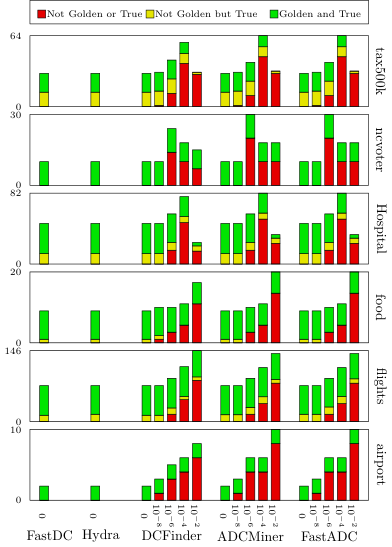

In [20]:
pic = tikz.Picture()

image(pic)
#Use demo to directly see the image. Needs latex locally installed
pic.demo(dpi=100)
#Use print to obtain tikzpicture code to compile elsewhere
#print(pic.code())